In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# mount the google drive
from google.colab import drive
drive.mount("/content/drive/")

path_to_files = "/content/drive/MyDrive/MachineLearning/lab_1/"
output_dir = "/content/drive/MyDrive/MachineLearning/lab_1/outpus/"

Mounted at /content/drive/


## Test the initial accuraty without any feature selection

 - With RandomForest classifier
 - Parameters are n_estimators=100 and the random_state=42

In [10]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [4]:
# read data
train = pd.read_csv(path_to_files + "train.csv")
validation = pd.read_csv(path_to_files + "valid.csv")

In [5]:
# drop label_2, label_3 and label_4
dropping_labels = ["label_1","label_3", "label_4"]
train = train.drop(dropping_labels, axis=1)
validation = validation.drop(dropping_labels, axis=1)

In [20]:
# check whether any missing values in the train set
print(train.columns[train.isnull().any()])
print(validation.columns[validation.isnull().any()])

Index(['label_2'], dtype='object')
Index(['label_2'], dtype='object')


In [21]:
train.dropna(inplace=True)
validation.dropna(inplace=True)

In [22]:
# splitting features and the label
x_train = train.drop(["label_2"], axis=1)
y_train = train["label_2"]
x_test = validation.drop(["label_2"], axis=1)
y_test = validation["label_2"]

In [23]:
# Initializing the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier on the training data
rf_classifier.fit(x_train, y_train)

# Making predictions on the testing data
y_pred = rf_classifier.predict(x_test)

# Calculating the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9225543478260869


## Step 1 : Handing Missing Values

In [24]:
# check whether any missing values in train or validation sets
print("Columns with missing values in train set: ",train.columns[train.isnull().any()])
print("Columns with missing values in validation set: ",validation.columns[validation.isnull().any()])

Columns with missing values in train set:  Index([], dtype='object')
Columns with missing values in validation set:  Index([], dtype='object')


## 02. Using the variance threshould method

In [25]:
# check for minimum variance
print("Minimum variance found is: ",x_train.describe().loc['std'].min()**2)

Minimum variance found is:  0.6569569480919141


Since the minimum variance is 0.6658, no need of using variance threshould method

## 03. Using Corellation

In [26]:
# The bellow function returns all the co-related features
def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j])>= threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [27]:
correlation(x_train, 0.85)

set()

The function returns empty set, that means no highly co-related values in the dataset.

## Step 4: Scalling

In [28]:
# define the scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit the scaler
sx_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
sx_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

## Step 5: Feature Importance

In [29]:
# Initializing the Random Forest classifier
rfi_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier on the training data
rfi_classifier.fit(x_train, y_train)

# Making predictions on the testing data
y_pred = rfi_classifier.predict(x_test)

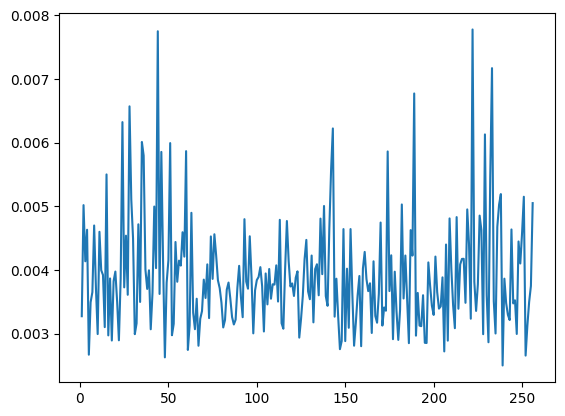

In [30]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(1,len(rfi_classifier.feature_importances_)+1)] ,rfi_classifier.feature_importances_)

In [32]:
def getDroppingFields(feature_importances, threshold):
  dropping_labels = []
  for i in range(len(feature_importances)):
    if feature_importances[i]<=threshold:
      dropping_labels.append(f"feature_{i+1}")
  return dropping_labels

should_dropped = getDroppingFields(rfi_classifier.feature_importances_, 0.0032)
print(f"Dropping {len(should_dropped)} features")

rsx_train = sx_train.drop(should_dropped, axis=1)
rsx_test = sx_test.drop(should_dropped, axis=1)

Dropping 52 labels


## Step 6: Principal Component Analysis

In [64]:
# define the pca
from sklearn.decomposition import PCA
pca = PCA(n_components=90)

prsx_train = pca.fit_transform(rsx_train)
prsx_test = pca.transform(rsx_test)

## Step 7: Classification while handling imbalances in the Dataset

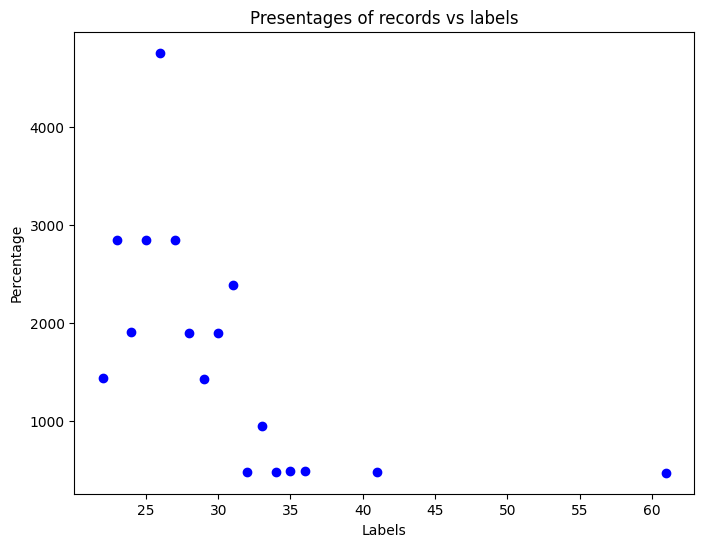

In [65]:
label_counts = train['label_2'].value_counts()
tot_records = len(train)
percentages = {}
for index, count in label_counts.items():
  percentages[index] = count

lbls = []
ptages = []
for key, value in sorted(percentages.items()):
  lbls.append(key)
  ptages.append(value)

# Create a scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size (width, height)

plt.scatter(lbls, ptages, color='blue', marker='o', label='Data Points')  # Create scatter plot
plt.title('Presentages of records vs labels')  # Set the title of the plot
plt.xlabel('Labels')  # Set the label for the x-axis
plt.ylabel('Percentage')  # Set the label for the y-axis

plt.show()  # Display the plot

In [66]:
for key, value in percentages.items():
  if value>=2000:
    percentages[key] = 2000

Since there is no category with higher presentage of data. Dataset is not a imbalance one. Hense no need of handling imbalances.

In [67]:
from imblearn.under_sampling import RandomUnderSampler

# define undersampler
undersampler = RandomUnderSampler(sampling_strategy=percentages)

# Apply the undersampling to your training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(prsx_train, y_train)

# Initializing the Random Forest classifier
prf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier on the training data
prf_classifier.fit(X_train_resampled, y_train_resampled)

# Making predictions on the testing data
prsy_pred = prf_classifier.predict(prsx_test)

# Calculating the accuracy of the classifier
accuracy = accuracy_score(y_test, prsy_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9334239130434783


## Creation of submision *csv* file

In [68]:
# load test dataset
f_test = pd.read_csv(path_to_files + "test.csv")
f_test = f_test.drop(['label_1','label_2','label_3','label_4'], axis=1)

# label prediction before feature selection
label2_pred_before = rf_classifier.predict(f_test)

# label prediction after feature selection
df_test = f_test.drop(should_dropped, axis=1)
pdf_test = pca.transform(df_test)

label2_pred_after = prf_classifier.predict(pdf_test)

In [69]:
pred_df = pd.DataFrame(label2_pred_before, columns=['Predicted labels before feature engineering'])
pred_df['Predicted labels after feature engineering'] = label2_pred_after
pred_df['No of new features'] = pdf_test.shape[1]

features_df = pd.DataFrame(pdf_test, columns=[f"new_feature_{i}" for i in range(1, pdf_test.shape[1]+1)])
submition_df = pd.concat([pred_df,features_df], axis=1)
submition_df.head()

,Predicted labels before feature engineering,Predicted labels after feature engineering,No of new features,new_feature_1,new_feature_2,new_feature_3,new_feature_4,new_feature_5,new_feature_6,new_feature_7,...,new_feature_81,new_feature_82,new_feature_83,new_feature_84,new_feature_85,new_feature_86,new_feature_87,new_feature_88,new_feature_89,new_feature_90
0,26.0,25.0,90,-1.631154,4.026087,1.055892,0.273497,6.337846,-1.310670,5.130512,...,-0.153379,0.626256,-1.420643,2.397487,0.208831,1.313687,-0.375089,0.985694,1.043061,-1.034863
1,25.0,28.0,90,-7.050340,7.616334,-4.323000,3.614993,9.071579,1.802743,-1.260178,...,1.381678,0.014903,-0.860910,2.075959,0.100919,0.247892,-0.124693,1.081713,0.253044,-0.656904
2,27.0,28.0,90,-4.343303,1.991349,-1.830401,4.245643,5.028455,-2.803188,-0.382203,...,0.429166,-0.462956,-1.017504,1.194501,0.945931,-0.040189,-0.385683,1.221367,0.181973,-1.117648
3,27.0,23.0,90,-2.274524,4.576076,0.803541,0.353811,-0.243107,2.357209,-1.640499,...,1.037484,0.016660,-0.873924,2.628525,0.578977,0.249450,-0.164159,1.308759,0.309889,-0.807396
4,27.0,27.0,90,0.920886,5.416670,-4.018564,2.423993,3.056489,-1.372615,2.138205,...,-0.596019,-1.015291,-0.350350,2.492665,-0.444188,0.388750,0.360422,0.954899,0.383812,-0.668306


In [71]:
submition_df.to_csv(output_dir+"190438H_label_2.csv",index = False)

In [70]:
len(submition_df[submition_df['Predicted labels before feature engineering']==submition_df['Predicted labels after feature engineering']])/len(submition_df)*100

60.8